# Labolatorium 3

### Autorzy:
Patryk Klatka \
Wojciech Łoboda

### Rekurencyjna kompresja macierzy z wykorzystaniem SVD

Rekurencyjna kompresja macierzy polega na przechowaniu macierzy w strukturze drzewa. Każdy węzeł odpowiada pewniej części macierzy i może być liściem lub posiadać czworo dzieci (reprezentują ćwiartki macierzy), korzeń reprezentuje całą macierz. Liść drzewa reprezentuje macierz skompresowaną za pomocą SVD lub blok zerowy. Decyzja o stworzeniu liścia podejmowana jest na podstawie warunku dopuszczalności ($ Sigma[r] < \epsilon $). 

### SVD
Każdą macierz rzeczywistą $A$ można przedstawić w postaci rozkładu SVD: 
$A = U \Sigma V^T$, gdzie $U$ i $V$ to pewne macierze ortogonalne a $\Sigma$ to macierz diagonalna, która na przekątnej ma nieujemne wartości szczególne macierzy $A$.

Truncated SVD to wersja w której maksymalny rozmiar $\Sigma$ jest podany a pozostałe wartości szczególne są ignorowane.

### Pseudokod

* v - aktualnie rozpatrywany węzeł.
* A - kompresowana macierz.
* t_min, t_max, s_min, s_max - zakresy wierszy i kolumn dla węzła.
* r, $\epsilon$ - parametry kompresji.

Kroki kompresji (wywołanie compress(v)):

* ($U$, $\Sigma$, $V$) = truncatedSVD(A[t_min:t_max, s_min:s_max], r + 1)
* IF ($\Sigma[r, r] < \epsilon$) THEN:
    * aktualny węzeł zostaje liściem, zapisanie $U, \Sigma, V$.
* ELSE:
    * t_newmax = (t_min + t_max) / 2.
    * s_newmax = (s_min + s_max) / 2.
    * v.children[0] = create_node($A$, t_min, t_newmax, s_min, s_newmax), compress(v.children[0]).
    * v.children[1] = create_node($A$, t_min, t_newmax, s_newmax, s_max), compress(v.children[1]).
    * v.children[2] = create_node($A$, t_newmax, t_max, s_min, s_newmax), compress(v.children[2]).
    * v.children[3] = create_node($A$, t_newmax, t_max, s_newmax, s_max), compress(v.children[3]).

In [2]:
from sklearn.utils.extmath import randomized_svd
import numpy as np

class MatrixTree:
    def __init__(self, matrix, row_min, row_max, col_min, col_max):
        self.matrix = matrix
        self.row_min = row_min
        self.row_max = row_max
        self.col_min = col_min
        self.col_max = col_max
        self.leaf = False
        self.children = None


    def compress(self, r, eps):
        U, Sigma, V = randomized_svd(self.matrix[self.row_min:self.row_max, self.col_min: self.col_max], n_components=r+1, random_state=0)
        if self.row_min + r == self.row_max or Sigma[r] <= eps:
            self.leaf = True
            if not self.matrix[self.row_min:self.row_max, self.col_min: self.col_max].any():
                self.rank = 0
            else:
                self.rank = len(Sigma)
                self.u = U
                self.s = Sigma
                self.v = V
        else:
            self.children = []
            row_newmax = (self.row_min + self.row_max)//2
            col_newmax = (self.col_min + self.col_max)//2
            self.children.append(MatrixTree(self.matrix, self.row_min, row_newmax, self.col_min, col_newmax))
            self.children.append(MatrixTree(self.matrix, self.row_min, row_newmax, col_newmax, self.col_max))
            self.children.append(MatrixTree(self.matrix, row_newmax, self.row_max, self.col_min, col_newmax))
            self.children.append(MatrixTree(self.matrix, row_newmax, self.row_max, col_newmax, self.col_max))

            for child in self.children:
                child.compress(r, eps)
    
    def decompress(self, output_matrix):
        if self.leaf:
            if self.rank != 0:
                sigma = np.zeros((self.rank,self.rank))
                np.fill_diagonal(sigma, self.s)
                output_matrix[self.row_min:self.row_max, self.col_min: self.col_max] = self.u @ sigma @ self.v #zeros
            else:
                output_matrix[self.row_min:self.row_max, self.col_min: self.col_max] = self.matrix[self.row_min:self.row_max, self.col_min: self.col_max]
        else:
            for child in self.children:
                child.decompress(output_matrix)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

def draw_tree(root, title=''):
    image = np.ones(root.matrix.shape)*255
    Q = deque()
    Q.append(root)
    while Q:
        v = Q.pop()
        if v.leaf:
            image[v.row_min:v.row_max, v.col_min:v.col_min+v.rank] = np.zeros((v.row_max - v.row_min, v.rank))
            image[v.row_min:v.row_min+v.rank, v.col_min:v.col_max] = np.zeros((v.rank , v.col_max - v.col_min))
            image[v.row_min, v.col_min:v.col_max] = np.zeros((1,v.col_max - v.col_min))
            image[v.row_max-1, v.col_min:v.col_max] = np.zeros((1,v.col_max - v.col_min))
            image[v.row_min:v.row_max,v.col_min] = np.zeros(v.row_max-v.row_min)
            image[v.row_min:v.row_max,v.col_max-1] = np.zeros(v.row_max-v.row_min)
        else:
            for child in v.children:
                Q.append(child)

    plt.imshow(image, cmap="gist_gray", vmin=0, vmax=255)
    plt.title(title)
    plt.show()

In [4]:
def generate_matrix(n, ratio):
    return np.multiply(np.random.choice([0, 1], size=(n, n), p=[1 - ratio, ratio]), np.random.uniform(0.00000001, 1, (n, n)))

ratios = [0.01, 0.02, 0.05, 0.1, 0.2]
k = 2 ** 10
test_matrices = [generate_matrix(k, r) for r in ratios]

### Porównanie wartości sigma

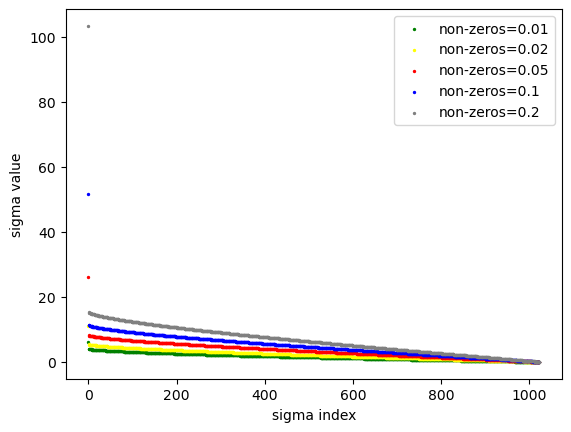

In [5]:
def draw_sigmas(sigmas):
    _, ax = plt.subplots()
    l = len(sigmas[0])
    ax.set_ylabel('sigma value')
    ax.set_xlabel('sigma index')
    ax.scatter([i for i in range(l)], sigmas[0], color='green', s=2, label="non-zeros=0.01")
    ax.scatter([i for i in range(l)], sigmas[1], color='yellow', s=2, label="non-zeros=0.02")
    ax.scatter([i for i in range(l)], sigmas[2], color='red', s=2, label="non-zeros=0.05")
    ax.scatter([i for i in range(l)], sigmas[3], color='blue', s=2, label="non-zeros=0.1")
    ax.scatter([i for i in range(l)], sigmas[4], color='grey', s=2, label="non-zeros=0.2")
    ax.legend()
    plt.show()


sigmas = [randomized_svd(m, n_components=k, random_state=0)[1] for m in test_matrices]
draw_sigmas(sigmas)

### Czas kompresji macierzy i dokładność.

In [6]:
from time import perf_counter
import pandas as pd

df = pd.DataFrame(columns=['non-zeros', 'b', 'sigma', 'time', 'error'])
trees = {}

for index, m in enumerate(test_matrices):
    for b, sigma, sigma_str in \
            [(1, sigmas[index][1], 'sigmas[1]'), (1, sigmas[index][k//2], 'sigmas[k/2]'), (1, sigmas[index][k - 1], 'sigmas[k-1]'), 
             (4, sigmas[index][1], 'sigmas[1]'),  (4, sigmas[index][k//2], 'sigmas[k/2]'), (4, sigmas[index][k - 1], 'sigmas[k-1]')]:
        root = MatrixTree(m, 0, k, 0, k)
        start = perf_counter()
        root.compress(b, sigma)
        end = perf_counter()
        output_matrix = np.zeros(test_matrices[index].shape)
        root.decompress(output_matrix)
        new_row = {'non-zeros': ratios[index], 'b': b, 'sigma': sigma_str, 'time': end - start, 'error': np.linalg.norm(output_matrix - test_matrices[index])}
        df.loc[len(df)] = new_row
        trees[(index, b, sigma_str)] = root


In [7]:
print(df.to_string(formatters={'non-zeros':'{:,.2f}'.format, 'error':'{:.2E}'.format, 'time':'{:,.2f}s'.format}, index=False))

non-zeros  b       sigma    time    error
     0.01  1   sigmas[1]   0.03s 5.91E+01
     0.01  1 sigmas[k/2]   0.68s 5.08E+01
     0.01  1 sigmas[k-1]   8.92s 5.00E-15
     0.01  4   sigmas[1]   0.04s 5.87E+01
     0.01  4 sigmas[k/2]   0.70s 4.45E+01
     0.01  4 sigmas[k-1]   3.60s 4.30E-14
     0.02  1   sigmas[1]   0.03s 8.29E+01
     0.02  1 sigmas[k/2]   0.52s 7.61E+01
     0.02  1 sigmas[k-1]  35.38s 7.74E-15
     0.02  4   sigmas[1]   0.06s 8.24E+01
     0.02  4 sigmas[k/2]   0.62s 7.46E+01
     0.02  4 sigmas[k-1]  11.72s 6.56E-14
     0.05  1   sigmas[1]   0.04s 1.29E+02
     0.05  1 sigmas[k/2]   0.73s 1.25E+02
     0.05  1 sigmas[k-1]  89.67s 1.45E-14
     0.05  4   sigmas[1]   0.03s 1.28E+02
     0.05  4 sigmas[k/2]   0.84s 1.19E+02
     0.05  4 sigmas[k-1]  20.80s 1.10E-13
     0.10  1   sigmas[1]   0.02s 1.79E+02
     0.10  1 sigmas[k/2]   0.27s 1.75E+02
     0.10  1 sigmas[k-1]  53.56s 4.84E-03
     0.10  4   sigmas[1]   0.03s 1.78E+02
     0.10  4 sigmas[k/2]   0.28s 1

### Wizualizacja skompresowanych macierzy

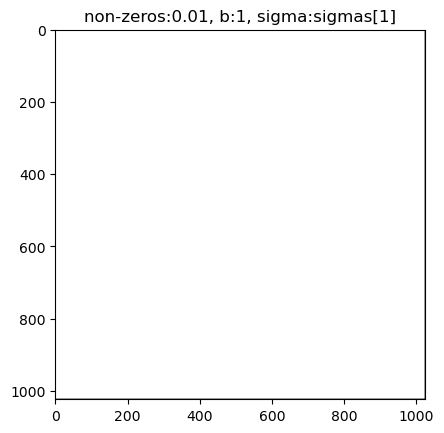

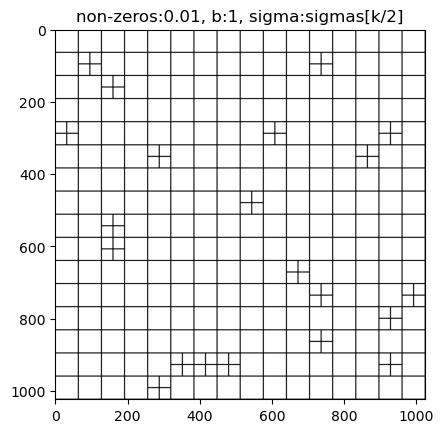

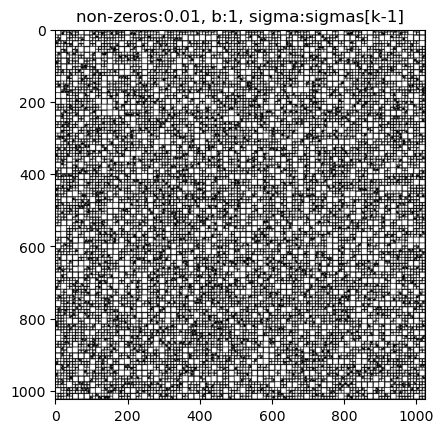

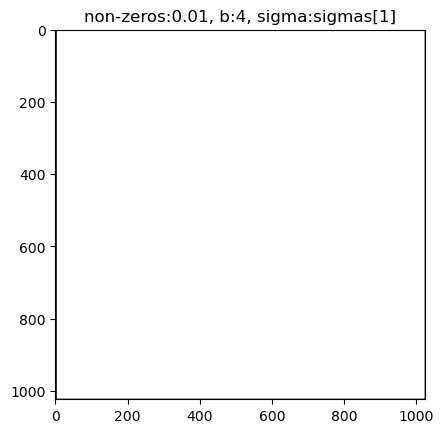

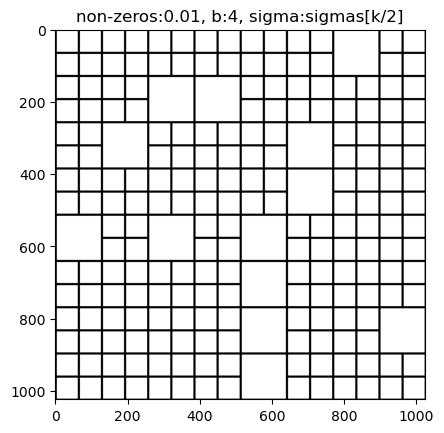

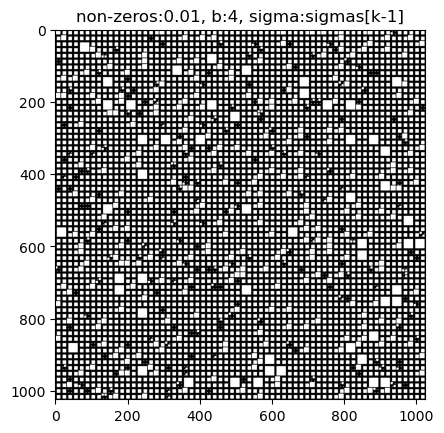

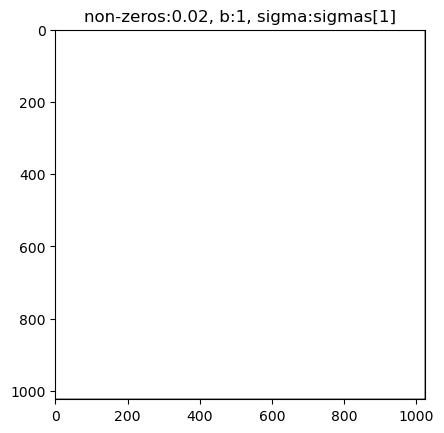

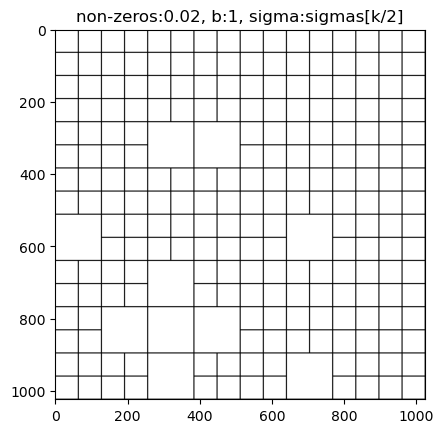

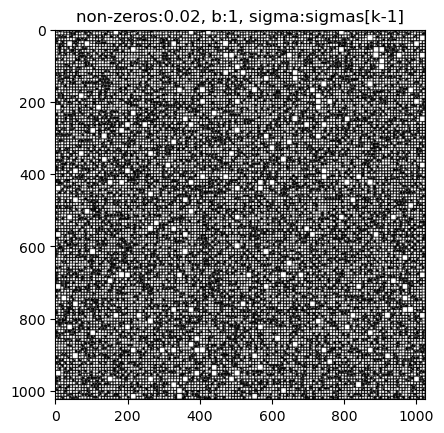

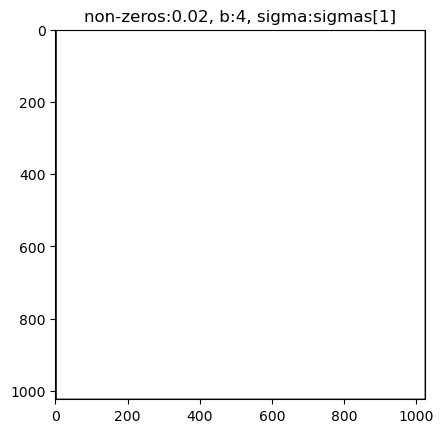

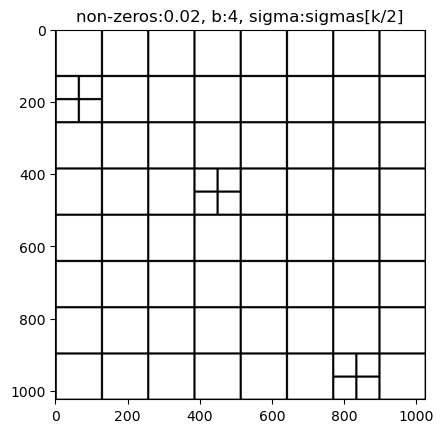

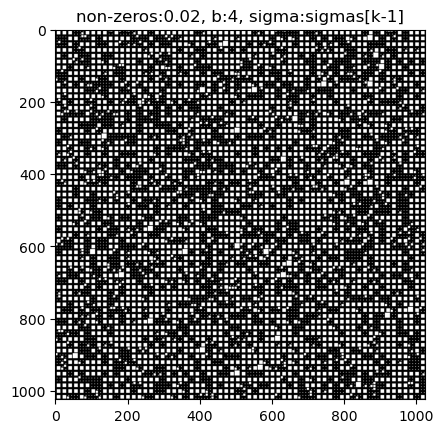

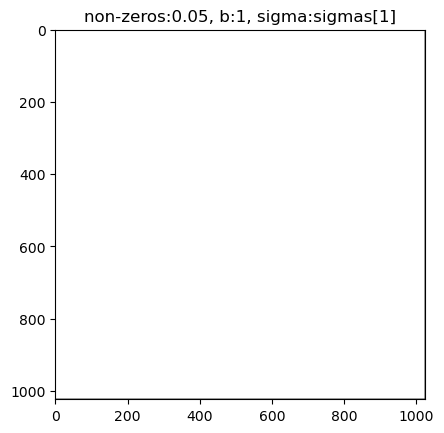

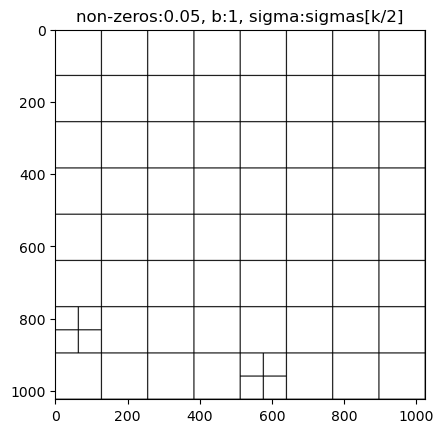

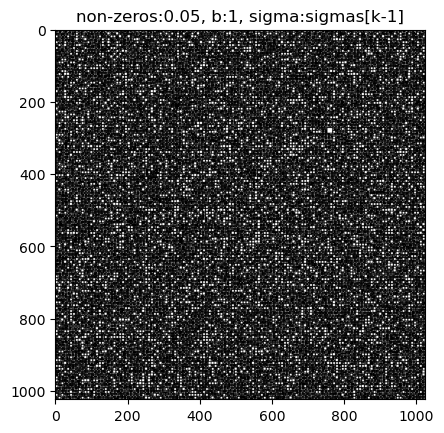

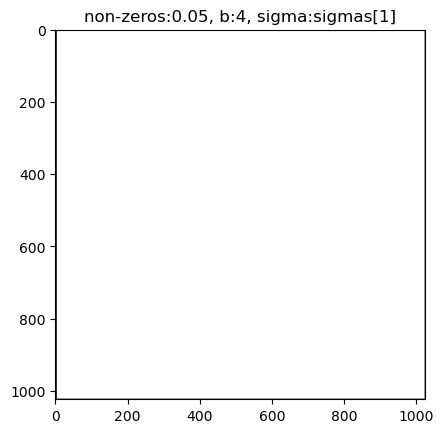

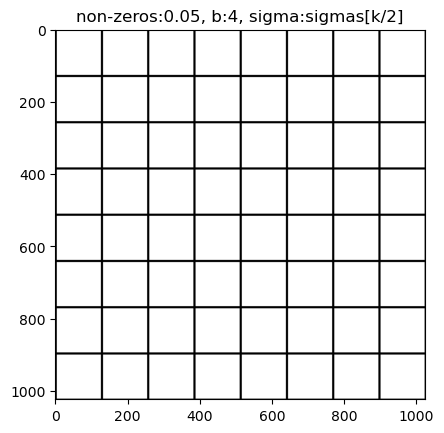

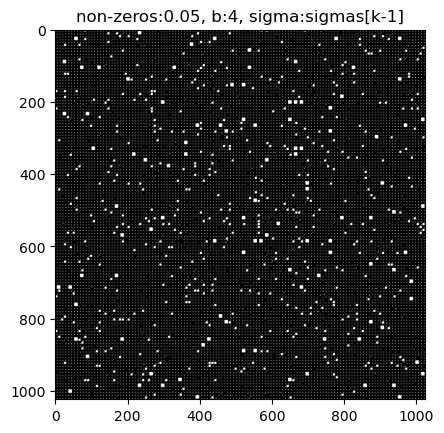

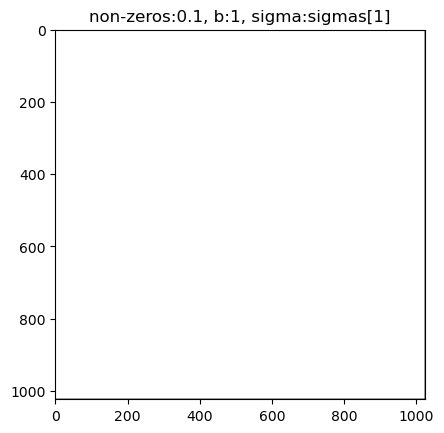

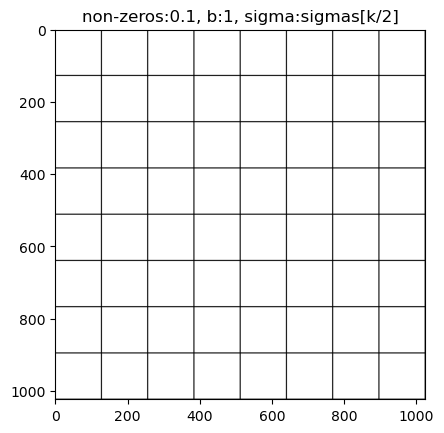

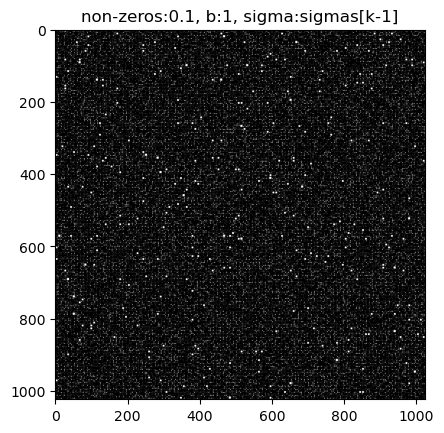

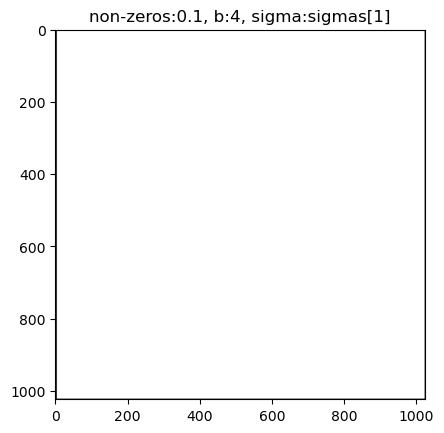

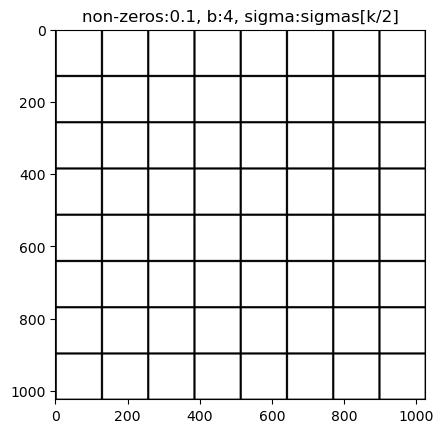

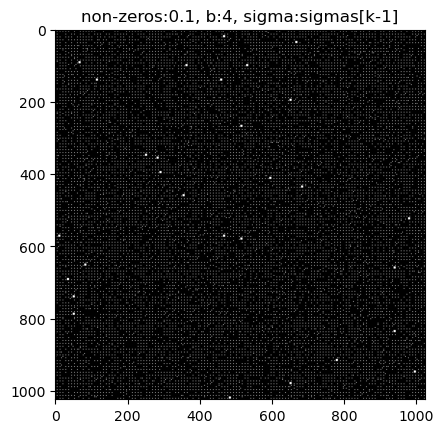

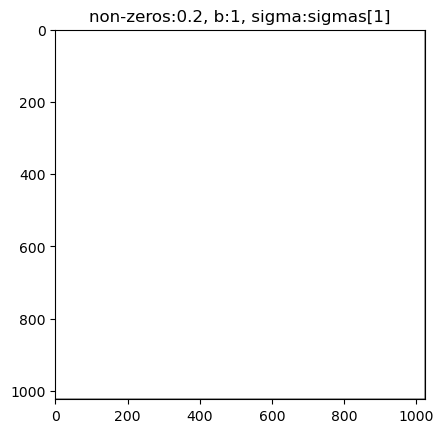

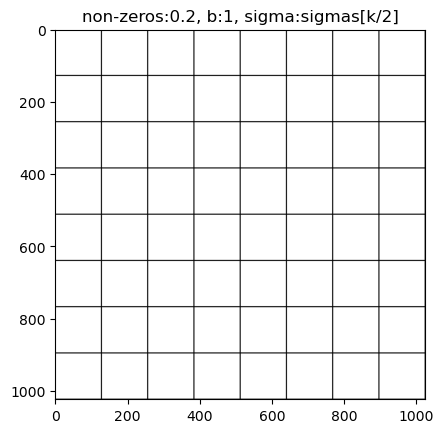

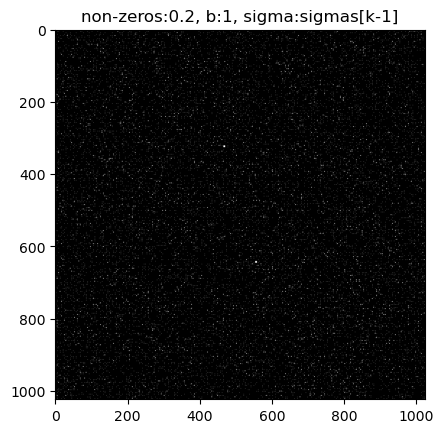

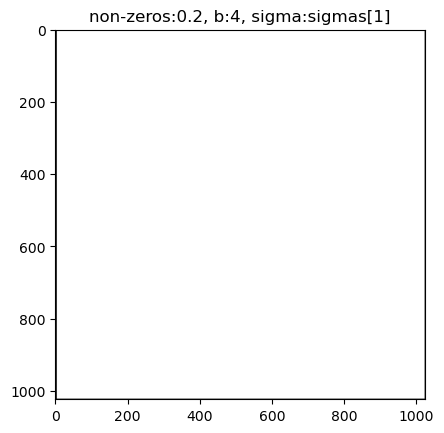

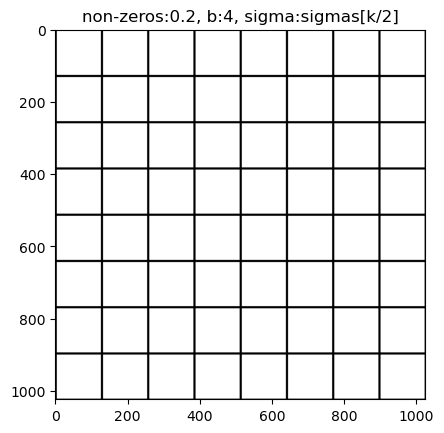

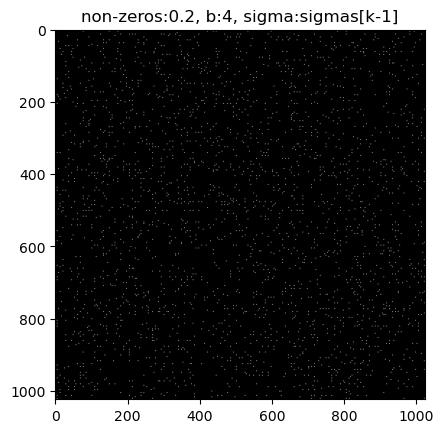

In [8]:
for index, b, sigma in trees:
    draw_tree(trees[(index, b, sigma)], title=f'non-zeros:{ratios[index]}, b:{b}, sigma:{sigma}') 

### Wnioski

Przy SVD dla całej macierzy pierwsza wartość szczególna jest znacznie większa niż pozostałe. Im macierz posiada więcej wartości niezerowych
tym większe są jej wartości szczególne (Sigma). Czas kompresji zależy istotnie od wartości parametru $\epsilon$ i liczby 
wartości niezerowych w macierzy. Im mniejszy $\epsilon$ lub im więcej wartości niezerowych tym kompresja trwa dłużej. Błąd 
przybliżenia wartości jest tym im mniejszy $\epsilon$ i im mniej jest wartości niezerowych w macierzy. Również głębokość drzewa różni się w zależności od 
doboru parametru $\epsilon$, im mniejszy tym drzewo kompresji jest głębsze a macierz bardziej podzielona. 